In [1]:
pip install shap flaml

Note: If you want to re-run the AutoML code, you may need to downgrade NumPy and restart the session. After restarting, re-import NumPy. This step is only necessary if you intend to re-run the AutoML code.

In [2]:
# Downgrade NumPy and then restart the session by clicking the Runtime tab
!pip uninstall -y numpy
!pip install numpy==1.26.3

Found existing installation: numpy 1.26.3
Uninstalling numpy-1.26.3:
  Successfully uninstalled numpy-1.26.3
  Using cached numpy-1.26.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)


In [3]:
from flaml import AutoML

**self note**

I first tried [1]-[2]-[3], but resulted error. Restart Runtime session. Then rerun [1]-[2]-[3] successfully. Gemini explained that current runtime may still remain old package of software environment. Just renew a runtime session will solve. Similar as reboot a PC after sw update.

In [7]:
import ipywidgets as widgets # ipywidgets are interactive elements in Jupyter environment
import matplotlib.pyplot as plt # matlab style interface for ploting in python
import numpy as np
import pandas as pd
import seaborn as sns
import shap # the prediction model interpreting tool SHapley...

# from flaml import AutoML
from sklearn.cluster import KMeans # algorithm to cluster data into K distinct groups
from sklearn.datasets import load_wine # Wine recognition dataset used for classification jobs
from sklearn.decomposition import PCA # Principal Component Analysis (PCA) reduce features into a new, smaller set of variables called Principal Components.
from sklearn.ensemble import ( # Below, sklearn.ensemble combines the four models into a more robust/accurate prediction model.
    GradientBoostingClassifier,
    GradientBoostingRegressor,
    RandomForestClassifier,
    RandomForestRegressor,
)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier

# **Assignment: Understanding House Price Prediction Using Regression Models**

**Objective:**
The goal of this assignment is to explore the relationship between house prices and various features
using exploratory data analysis (EDA) and regression models. By the end of the assignment, students
will be able to visualize data, apply regression techniques, and compare model performances. Before
we get started, we import all the packages used in this problem set.


# **Part 1: Dataset Overview and Preprocessing**

1.**Dataset Overview**

The dataset contains house sale prices and various features such as:

**date:** The date the house was sold.

**price:** Target variable representing house sale prices.

**bedrooms:** Number of bedrooms.

**bathrooms:** Number of bathrooms.

**sqft_living:** Square footage of the living space.

**sqft_lot:**Square footage of the lot.

**floors:** Number of floors.

**waterfront:** Indicator if the house is located on a waterfront.

**view:** View rating of the house.

**condition:** Condition rating of the house.

**sqft_above:** Square footage of the living space above ground.

**sqft_basement:** Square footage of the basement.

**yr_built:** Year the house was built.

**yr_renovated:** Year of renovation (0 if never renovated).

**street:** Street address of the property. (NaN)

**city:** City where the house is located. (NaN)

**statezip:** State and zip code. (NaN)

**country:** Country of the property. (NaN)

The dataset includes both numerical and categorical features.

Check the first few rows of the dataset:

In [8]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/chansen776/MBA-ML-Course-Materials/refs/heads/main/Data/house_prices.csv"
)
print(df.head())

                  date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0  2014-05-02 00:00:00   313000.0       3.0       1.50         1340      7912   
1  2014-05-02 00:00:00  2384000.0       5.0       2.50         3650      9050   
2  2014-05-02 00:00:00   342000.0       3.0       2.00         1930     11947   
3  2014-05-02 00:00:00   420000.0       3.0       2.25         2000      8030   
4  2014-05-02 00:00:00   550000.0       4.0       2.50         1940     10500   

   floors  waterfront  view  condition  sqft_above  sqft_basement  yr_built  \
0     1.5           0     0          3        1340              0      1955   
1     2.0           0     4          5        3370            280      1921   
2     1.0           0     0          4        1930              0      1966   
3     1.0           0     0          4        1000           1000      1963   
4     1.0           0     0          4        1140            800      1976   

   yr_renovated                    str

2.**Feature Engineering & Encoding Categorical Data**

Convert categorical features (city, statezip, street) into numerical representations.

Apply one-hot encoding where necessary:

**self note**

*Country*

If there more than 1 country, perform one-hot encoding:

    df_encoded = pd.get_dummies(df_encoded, columns=['country'], prefix='country')

If there's only one country, it might not be informative for modeling:

    # Leave it as is (add no variance = make no difference)

*Street*

has a very large number of unique values, One-hot encoding result in a very high-dimensional, sparse dataset.

<u>Option 1</u> One-Hot Encoding with caution：

    df_encoded = pd.get_dummies(df_encoded, columns=['street'], prefix='street')

<u>Option 2</u> Frequency Encoding (Count the occurrences of each street)：

    street_counts = df['street'].value_counts()
    df_encoded['street_freq'] = df['street'].map(street_counts)
    # Drop the original 'street' column
    df_encoded.drop('street', axis=1, inplace=True)

<u>Option 3</u> Target Encoding (Encode based on the target variable 'price'). This method can be more informative,  but must be careful to avoid data leakage especially during cross-validation:

    street_means = df.groupby('street')['price'].mean()
    df_encoded['street_target'] = df['street'].map(street_means)
    # Drop the original 'street' column
    df_encoded.drop('street', axis=1, inplace=True)


In [9]:
df = pd.get_dummies(df, columns=["city", "statezip"], drop_first=True)

3.**Feature Scaling**

Important: When standardizing data, ensure that the scaling is performed <u>only on the training data</u> to prevent data leakage.

The mean and standard deviation should be calculated from the training data and then applied to both the training and test sets.

In [11]:
# Define predictor and target variable
X = df[["sqft_living"]] # [[...]] denotes a DataFrame, so use upper case X to denote.
y = df["price"] # [...] denotes a series, so use a lower case y to denote.

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42 # set random_state any integer ensures that data split same way each time and same result is reproduced.
)

# Initialize the StandardScaler, scaling data to its variance.
scaler = StandardScaler()

# Fit scaler only on training data and transform both training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # No fit() on test data to avoid leakage.

# **Part 2: Exploratory Data Analysis (EDA)**

**Visualization**

1.Scatter Plot of sqft_living vs. price



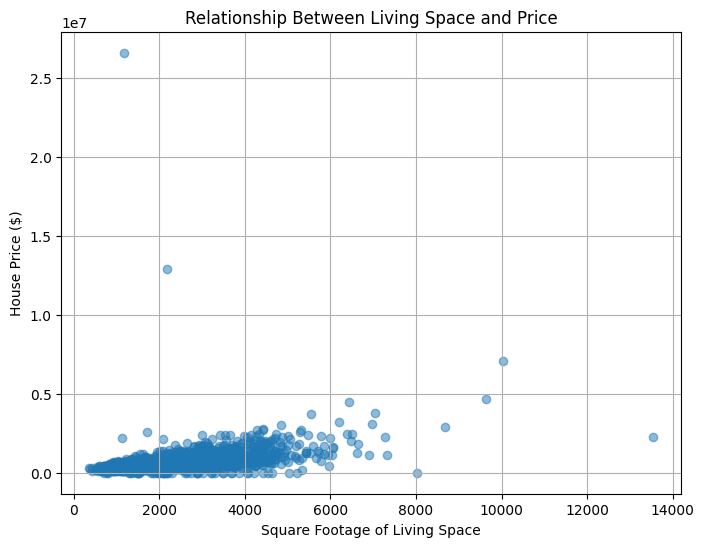

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(df["sqft_living"], df["price"], alpha=0.5)
plt.xlabel("Square Footage of Living Space")
plt.ylabel("House Price ($)")
plt.title("Relationship Between Living Space and Price")
plt.grid(True)
plt.show()

2.**Task:**Create a scatter plot of sqft_basement vs. price.

You have code for the scatter plot of sqft_living vs. price above.

The variable name you need is sqft_basement.

You can use ChatGPT or any other LLM to ask how to modify the provided code.

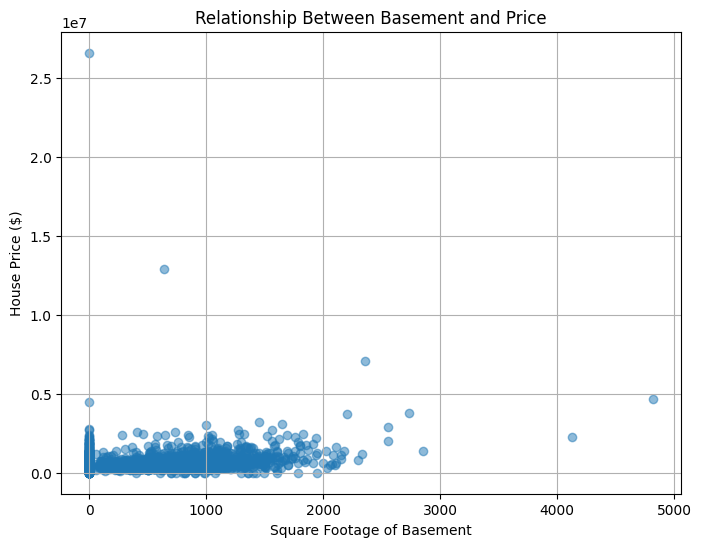

In [14]:
# Insert code and plot here for Basement vs Price
plt.figure(figsize=(8, 6))
plt.scatter(df["sqft_basement"], df["price"], alpha=0.5)
plt.xlabel("Square Footage of Basement")
plt.ylabel("House Price ($)")
plt.title("Relationship Between Basement and Price")
plt.grid(True)
plt.show()

In [15]:
# Calculate the correlation coefficient between 'sqft_living' and 'price'
corr_liv_pri = df['sqft_living'].corr(df['price'])

# Print the result
print(f"The correlation coefficient between sqft_living and price is: {corr_liv_pri}")

# Calculate the correlation coefficient between 'sqft_living' and 'price'
corr_bas_pri = df['sqft_basement'].corr(df['price'])

# Print the result
print(f"The correlation coefficient between sqft_basement and price is: {corr_bas_pri}")

The correlation coefficient between sqft_living and price is: 0.43041002543262824
The correlation coefficient between sqft_basement and price is: 0.21042657177482943


3.**Question:** Which feature do you think has a stronger correlation with price: sqft_living or sqft_basement? Calculate the correlation coefficient for both and explain your reasoning.

**Frank Answer**

Intuitively, sqft_living and price should have stronger correlation because that's what homebuyers do.

Calculation results tell same story:

corr_liv_pri = 0.43

corr_bas_pri = 0.21



# **Part 3: Building Regression Models**

1.Linear Regression (Example Given)

2.Train a **Linear Regression model** using sqft_living as the predictor.

3.Evaluate the model using R-squared (R²), Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE)

In [26]:
# define predictor and target variables
X = df[["sqft_living"]]
y = df["price"]

# split dataset (X,y) into train and test 80-20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42 # tried with 100 randomness and restuled in R²=0,46, MAE=178184 RMSE=76845926073
)

# define prediction model and train it with data X and y
model = LinearRegression()
model.fit(X_train, y_train)

# predict target variable using trained model above.
y_pred = model.predict(X_test)

print("R²:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))

R²: 0.029065410341410414
MAE: 225375.25345857345
RMSE: 990204087727.1417


**Random Forest and Gradient Boosting Regression**

Below is the code for Random Forest and Gradient Boosting Regression. Do not worry about understanding every part of the code initially.


In [27]:
# Random Forest Regressor, here use scaled X_train to train model; can also use non-scaled X_train.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42) #  n_estimators = number of trees built in the random forest.
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

print("Random Forest Results:")
print("R²:", r2_score(y_test, y_pred_rf))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

print("-----model seperator-----")

# Gradient Boosting Regressor, here use scaled X_train to train model; can also use non-scaled X_train.
gb_model = GradientBoostingRegressor(
    n_estimators=100, learning_rate=0.1, random_state=42 # learning_rate=λ, the contribution of each tree to the final prediction.
)
gb_model.fit(X_train_scaled, y_train)
y_pred_gb = gb_model.predict(X_test_scaled)

print("Gradient Boosting Results:")
print("R²:", r2_score(y_test, y_pred_gb))
print("MAE:", mean_absolute_error(y_test, y_pred_gb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gb)))

Random Forest Results:
R²: 0.005948601777127971
MAE: 233146.1318696576
RMSE: 1006866.2673542678
-----model seperator-----
Gradient Boosting Results:
R²: 0.006307078747391892
MAE: 224314.3204614628
RMSE: 1006684.7018355782


# **Your Task:**

1. Explain what the provided code is doing. You can use ChatGPT or any LLM to help you understand it.

**Frank Explain**

RandomForest model samples 100 trees in each random forest, trained itself by scaled X_train and origal y_train, then predict y by scaled X-test, then produced R^2, MAE, and RMSE between prediction and y_test data.

GradientBoost model builds 100 training stages (trees) with learning rate (weight of each stage) of 0.1, trained itself by scaled X_train and origal y_train, then predict y by scaled X-test, then produced R^2, MAE, and RMSE between prediction and y_test data.

Compare the Results:

2. Which model performed better based on the evaluation metrics (R², MAE, RMSE)?

**Frank Answer**

by R²: gb is better

by MAE: rf is better

by RMSE: gb is margally better

Overall, gb is better than rf, but only by a marginal difference.

3. Consider the presence of outliers in the scatter plot from the beginning of the assignment.

**Frank Answer**

There are clearly a few outliers on the upper-left section.

4. Which evaluation metric (RMSE, R², or MAE) do you think is better for this example?

**Frank Answer**

Overall, RMSE and R² are better than MAE in this example for that they produce some consistency like 2-to-1 vote.

5. Explain your reasoning.

Think about how each metric handles outliers.

You can use ChatGPT to help think about the trade-offs.

**Hint:** We have used this example throughout most of Notes 1. If you set the seed to the same value used in those notebooks, you can compare your results.

**Frank Answer**

Consider the outliers, RMSE is better indicator because it stresses the large error/outlier. MAE down plays the outliers, comparing to RMSE. R² also stresses on outliers when indicating the portion of variance explanable.

# **Bonus Question:**

1.Experiment by adding more features (e.g., bedrooms, bathrooms, sqft_basement).

2.Compare which model performs best with multiple predictors.

//

tbd

\\
---

#  Multi-class Classification

In many predictive modeling tasks, the goal is to classify observations into distinct categories based on their characteristics. When there are only two possible categories (e.g., "Yes" or "No," "Up" or "Down"), the problem is called binary classification. However, when there are **more than two possible categories**, we use **multi-class classification**.

An automobile company is expanding into new markets with its existing products. Market research shows that customer behavior in these markets mirrors the existing one.

Previously, the sales team classified customers into four segments (A, B, C, D) using rule-based methods based on demographics, spending behavior, and past purchases. To scale this approach, the company now requires a multi-class machine learning model to automate customer segmentation for new market entrants.

The A, B, C, D segmentation represents customer tiers in the automobile market:

* A (Loyal Customers) – High-spending, repeat buyers, likely to prefer premium or luxury cars.
* B (Regular Customers) – Moderate spenders, consistent buyers, often opting for mid-range vehicles.
* C (Occasional Customers) – Low-spending, infrequent buyers, likely considering budget-friendly or used cars.
* D (Potential Customers) – Least engaged, may be first-time buyers or exploring options with low commitment.

**Your task** is to develop a predictive solution that accurately assigns new customers to the appropriate segment, enabling data-driven decision-making and scalable outreach.




### Dataset_overview:

Dataset Overview
The dataset contains information about automobile customers. Each record represents an individual customer with various demographic and behavioral attributes. The key variables in the dataset include:

* **ID**: Unique identifier for each customer.
Gender: Customer's gender.
* **Ever_Married**: Indicates if the customer has ever been married.
* **Age**: Customer's age.
* **Graduated**: Indicates whether the customer is a graduate.
* **Profession**: Customer's occupation.
* **Work_Experience**: Number of years the customer has worked.
* **Spending_Score**: Indicates spending behavior, classified as Low, Average, or High based on purchasing patterns.
* **Family_Size**: Number of family members in the household.
* **Hidden_Customer_Category**: An internally assigned, anonymized classification of customers based on undisclosed criteria, such as spending behavior, or engagement patterns.

**Discussion Question: Binary vs. Multi-Class Classification** prior to predictive tasks.

If you were primarily interested in predicting who your potential customers are—perhaps so you can target them with incentives to encourage engagement—would you prefer a binary classification model (Potential Customer: 0/1) or a multi-class classification model that categorizes users into the four segments (A, B, C, D)? You could use ChatGPT to help you think these tradeoffs.

**Answer:**

Binary is good enough and even better in that it tells a direct, clear, and actionable answer to an essentially binary question (Y/N). It's like the situation of investment evaluation. Youd just want to know to invest or not today, but don't want to learn how much it may make you tomorrow.


## Task 1: Data Preprocessing and Exploration

### **1.1 Load and Explore the Dataset**  
- Load the **train and test datasets**.  
- Display summary statistics using `.describe()` and `.info()`.  



In [28]:
# change to your file directory
automobile_customers = pd.read_csv(
    "https://raw.githubusercontent.com/chansen776/MBA-ML-Course-Materials/refs/heads/main/Data/automobile_customer_segmentation.csv"
)
automobile_customers.info()
automobile_customers.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8570 entries, 0 to 8569
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        8500 non-null   float64
 1   Gender                    8570 non-null   object 
 2   Ever_Married              8453 non-null   object 
 3   Age                       8478 non-null   float64
 4   Graduated                 8481 non-null   object 
 5   Profession                8570 non-null   object 
 6   Work_Experience           8478 non-null   float64
 7   Spending_Score            8570 non-null   object 
 8   Family_Size               8471 non-null   float64
 9   Hidden_Customer_Category  8479 non-null   object 
 10  Segmentation              8570 non-null   object 
dtypes: float64(4), object(7)
memory usage: 736.6+ KB


,ID,Age,Work_Experience,Family_Size
count,8500.000000,8478.000000,8478.000000,8471.000000
mean,463544.991412,45.363883,4.197924,3.091134
std,2576.241780,16.155434,3.987977,1.625129
min,458985.000000,18.000000,0.000000,1.000000
25%,461420.000000,33.000000,1.000000,2.000000
50%,463584.500000,42.000000,2.000000,3.000000
75%,465730.000000,55.000000,8.000000,4.000000
max,467973.000000,89.000000,14.000000,9.000000


In [30]:
automobile_customers.isnull().sum()
automobile_customers.dropna(inplace=True)

**Question:** What are the two code lines above doing? (You could use your favorite LLM to help).

**Answer:**

isnull() finds the data rows that contains "null", or missing value. When there is a missing value, it returns boolean true. When there isn't, it returns boolean false.

sum() counts the boolean trues (as 1s).

dropna(inplace=True) drops the rows with missing values from the dataset, so the original dataset is modified.



### **1.2 Visualizing Categorical Variables Using Bar Plots**  

- Use **bar plots** to visualize the distribution of categorical variables.  
- Focus on key categorical features such as **Gender, Ever_Married, Graduated, Profession, Spending_Score, Hidden_Customer_Category, and Segmentation**.  
- Bar plots help understand the frequency of each category and identify potential imbalances.  


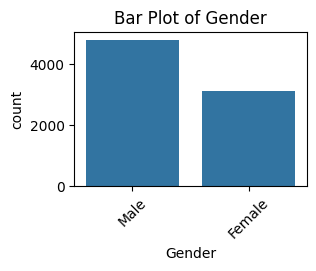

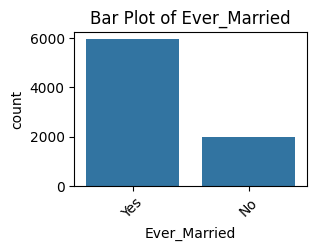

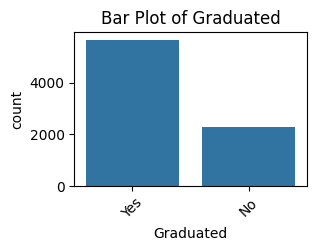

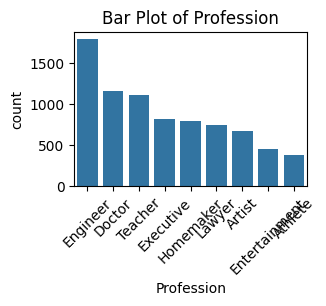

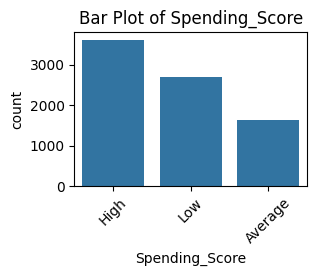

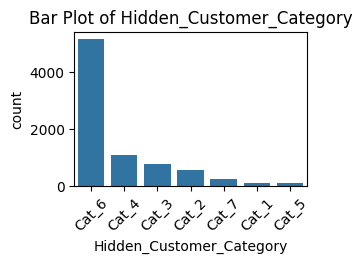

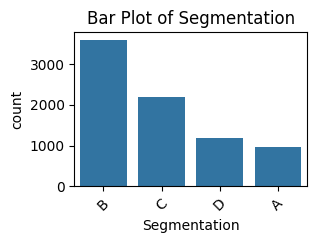

In [32]:
# Generate bar plots for each categorical column
categorical_cols = [
    "Gender",
    "Ever_Married",
    "Graduated",
    "Profession",
    "Spending_Score",
    "Hidden_Customer_Category",
    "Segmentation",
]

for col in categorical_cols:
    plt.figure(figsize=(3, 2))
    sns.countplot(
        x=automobile_customers[col],
        order=automobile_customers[col].value_counts().index,
    )
    plt.title(f"Bar Plot of {col}")
    plt.xticks(rotation=45)
    plt.show()

**self note**

there are

more college graduated, married, male engineers/doctors/teachers

than

non-college, never married, female athlets/entertainers/artists.

### **1.3 Discover Correlation with Other Variables**  
Investigate whether certain **demographic or behavioral attributes** are strong predictors of segmentation.


<ipython-input-34-695aa7727e83>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Segmentation", y=col, data=automobile_customers, palette="coolwarm")


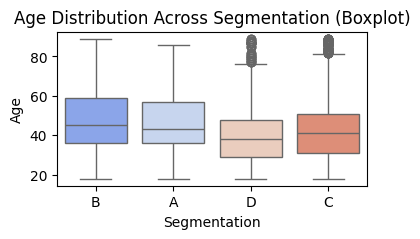

<ipython-input-34-695aa7727e83>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Segmentation", y=col, data=automobile_customers, palette="coolwarm")


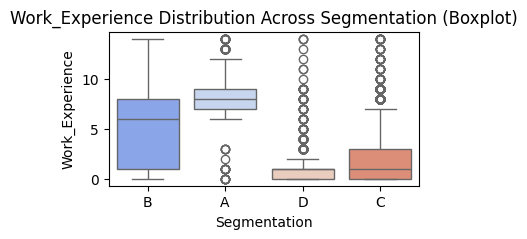

<ipython-input-34-695aa7727e83>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Segmentation", y=col, data=automobile_customers, palette="coolwarm")


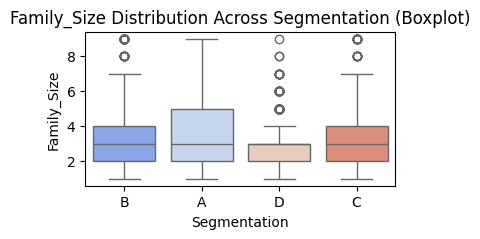

In [34]:
# Boxplots for Numerical Features vs. Segmentation
# Boxplots
numerical_cols = ["Age", "Work_Experience", "Family_Size"]

for col in numerical_cols:
    plt.figure(figsize=(4, 2))
    sns.boxplot(x="Segmentation", y=col, data=automobile_customers, palette="coolwarm")
    plt.title(f"{col} Distribution Across Segmentation (Boxplot)")
    plt.xlabel("Segmentation")
    plt.ylabel(col)
    plt.show()

**self note**

The college graduated, married, male engineers/doctors/teachers

vs

non-college, never married, female athlets/entertainers/artists

are more likely

**mid 30s - late 50s, mid-career, and from small-median housholds**

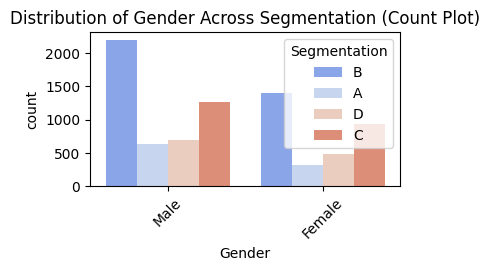

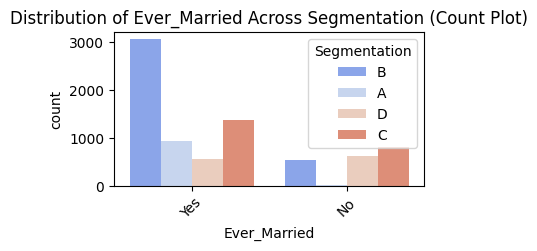

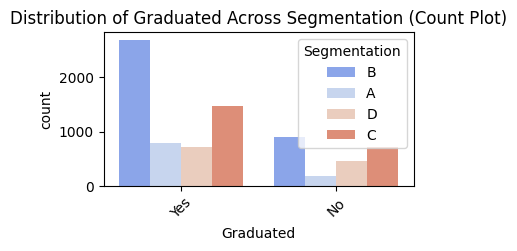

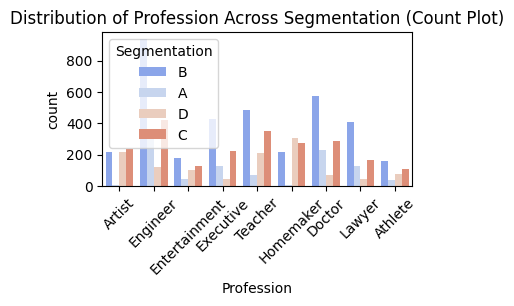

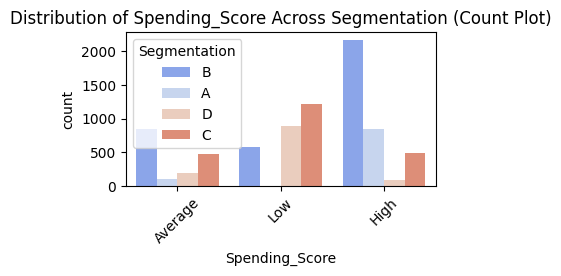

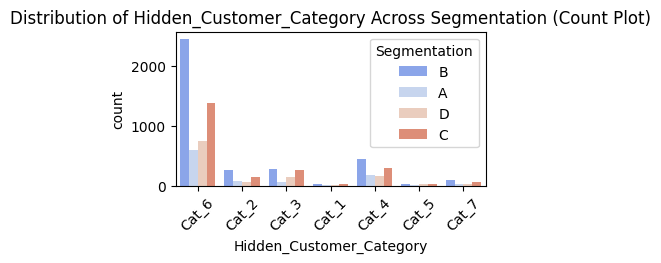

In [36]:
# Countplots for Categorical Features vs. Segmentation
# Countplots
categorical_cols = [
    "Gender",
    "Ever_Married",
    "Graduated",
    "Profession",
    "Spending_Score",
    "Hidden_Customer_Category",
]

for col in categorical_cols:
    plt.figure(figsize=(4, 2))
    sns.countplot(
        x=col, hue="Segmentation", data=automobile_customers, palette="coolwarm"
    )
    plt.title(f"Distribution of {col} Across Segmentation (Count Plot)")
    plt.xticks(rotation=45)
    plt.legend(title="Segmentation")
    plt.show()

**self note**

The college graduated, married, male engineers/doctors/teachers

vs

non-college, never married, female athlets/entertainers/artists

are more likely

mid 30s - late 50s, mid-career, and from small-median housholds

and unlikely

homemakers and low spending lifestyle

**Question:** Analyze and Interpret Data Insights
1. Summarize your key insights from the dataset, focusing on patterns or trends that could influence modeling decisions for customer segmentation.

2. Here, we examine the full dataset before modeling. Is there a potential issue with analyzing the entire dataset before constructing models based on these insights? What risks might arise from this approach?

**Answer:**

The auto customers can be stereotyped as college graduated, married, male engineers/doctors/teachers instead of non-college, never married, female athlets/entertainers/artists. They are mostly in their mid 30s - late 50s, mid-career, and from small-median housholds with high spending lifestyle, and very unlikely to be homemakers.

So doing all feature analysis can paint stereotypes, thus create a bias in our minds before objective data analysis. Remember, we are trying to analyze data for trend and prediction, then trying to discover explanations (theorizartion). If we have had a theory before data mining, such bias will affect our probability of finding truth.

### **1.4 Convert Categorical Variables and Encode Data**

**Encode categorical variables** using **LabelEncoder** for all categorical columns, except the target column `Segmentation`. **LabelEncoder** will be applied to **all categorical variables**, including both binary and multi-class categories.

In [37]:
# List of categorical columns (excluding the target 'Segmentation')
categorical_cols = [
    "Gender",
    "Ever_Married",
    "Graduated",
    "Profession",
    "Spending_Score",
    "Hidden_Customer_Category",
]

# Initialize LabelEncoder
encoder = LabelEncoder() # assign numeric values to NaN values in dataset.

# Loop through each categorical column and apply LabelEncoder
for col in categorical_cols:
    automobile_customers[col] = encoder.fit_transform(
        automobile_customers[col].astype(str)
    )

## **Task 2: Build & Compare Classification Models**

For Task 2, you'll follow these steps:

- 2.1 Split the dataset into train and test sets.

- 2.2 Train 3 multi-class classification models covered in Note2:
    - Logistic Regression
    - Decision Tree Classifier
    - Random Forest Classifier

- 2.3 Evaluate the models using performance metrics such as accuracy, precision, recall, F1-score, and confusion matrix.

### **2.1 Split the Dataset into Train and Test Sets**

   - Use **`train_test_split`** to split the data into **80% training** and **20% testing** sets.  
   - Ensure the split is **randomized** to help the model generalize (set_seed=`42`).


In [39]:
# Separate features (X) and target (y)
X = automobile_customers.drop(columns=["Segmentation", "ID"])
y = automobile_customers["Segmentation"]

# Perform the train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y # split dataset so that class distribution of target variable y across is balanced.
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (6352, 9)
Testing set shape: (1589, 9)


**Question:**
What did you notify about the `train_test_split` method? Why we use `stratify` parameter?

**Answer:**

Stratify is used to balance the y among classes during split when y has multiple classifications. It makes sure the data maintains balance after split, and both test and train are representative to the whole set.

### **2.2 Train 3 Multi-Class Classification Models**

 1. Train the following models using the prepared dataset:
    - **Decision Tree Classifier**
    - **Random Forest Classifier**
    - **Gradient Boosting Classifier**
 2. Since tree-based models do not require feature scaling, use the raw numerical features for training.
 3. **Perform Grid Search Cross-Validation (GridSearchCV) with 5-Fold Cross-Validation (cv=5)** to optimize hyperparameters
 4. Fit each model to the training dataset and generate predictions on the test dataset.
 5. Evaluate the models using accuracy, precision, recall, and F1-score, and analyze the results.


In [ ]:
# Define hyperparameter grid
param_grid_dt = {
    "max_depth": [10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

# Perform Grid Search
dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_dt,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2,
)
dt_grid.fit(X_train, y_train)

# Get best model and evaluate
best_dt = dt_grid.best_estimator_
y_pred_dt = best_dt.predict(X_test)

print("\nDecision Tree Best Parameters:", dt_grid.best_params_)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(
    "Decision Tree Classification Report:\n", classification_report(y_test, y_pred_dt)
)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV] END max_depth=10, mi

**Question:** Briefly explain what `GridSearchCV` is doing. Why we do cross-validation in the training dataset?

**Answer:**

//

tbd

\\
---

**Question:** Based on the classification report for decision tree, what do terms like precision, recall, F1-score mean? Briefly interpret the decision tree classifier results on the test dataset. (You could use ChatGPT to help interpretation.)

**Answer:**

//

tbd

\\
---

Training code for random forests with grid search cross-validation (would take around 5 minutes to run)

In [ ]:
# Random Forests
# Define hyperparameter grid
param_grid_rf = {
    "n_estimators": [500],
    "max_depth": [10, 20, 30],
    "min_samples_split": [2, 5, 10],
}

# Perform Grid Search
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2,
)
rf_grid.fit(X_train, y_train)

# Get best model and evaluate
best_rf = rf_grid.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("\nRandom Forest Best Parameters:", rf_grid.best_params_)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(
    "Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf)
)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END max_depth=10, min_samples_split=10, n_estimators=500; total time=   5.9s
[CV] END max_depth=10, min_samples_split=10, n_estimators=500; total time=   6.0s
[CV] END max_depth=10, min_samples_split=10, n_estimators=500; total time=   6.3s
[CV] END max_depth=10, min_samples_split=10, n_estimators=500; total time=   6.3s
[CV] END max_depth=10, min_samples_split=10, n_estimators=500; total time=   6.4s
[CV] END max_depth=10, min_samples_split=5, n_estimators=500; total time=   7.0s
[CV] END max_depth=10, min_samples_split=5, n_estimators=500; total time=   7.0s
[CV] END max_depth=10, min_samples_split=2, n_estimators=500; total time=   7.1s
[CV] END max_depth=10, min_samples_split=5, n_estimators=500; total time=   7.1s
[CV] END max_depth=10, min_samples_split=5, n_estimators=500; total time=   7.2s
[CV] END max_depth=10, min_samples_split=5, n_estimators=500; total time=   7.2s
[CV] END max_depth=10, min_samples_split=2, 

Considering time cost, training code for gradient boosting is **without grid search cross-validation**.

In [ ]:
# Pre-Selected GBM Hyperparameters, considering time cost
best_gb = GradientBoostingClassifier(
    n_estimators=200, max_depth=7, learning_rate=0.1, random_state=42
)

# Train the model
best_gb.fit(X_train, y_train)

# Make predictions
y_pred_gb = best_gb.predict(X_test)

# Evaluate performance
print("\nGradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))
print(
    "Gradient Boosting Classification Report:\n",
    classification_report(y_test, y_pred_gb),
)


Gradient Boosting Accuracy: 0.775330396475771
Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           A       0.79      0.79      0.79       193
           B       0.85      0.92      0.88       721
           C       0.70      0.66      0.68       438
           D       0.64      0.54      0.59       237

    accuracy                           0.78      1589
   macro avg       0.74      0.73      0.73      1589
weighted avg       0.77      0.78      0.77      1589



Confusion matrix for three tree models

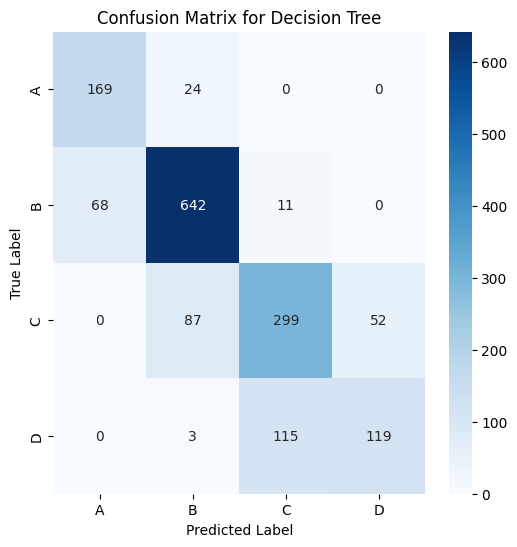

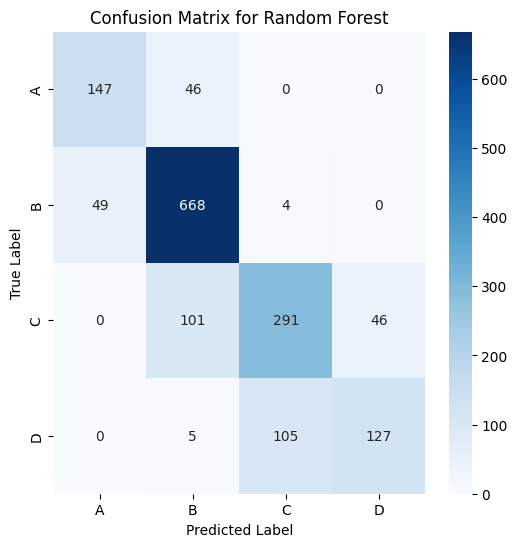

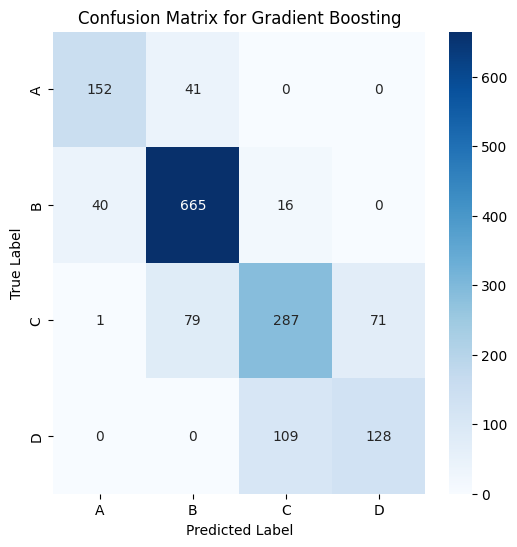

In [ ]:
for model, name in zip(
    [best_dt, best_rf, best_gb], ["Decision Tree", "Random Forest", "Gradient Boosting"]
):
    cm = confusion_matrix(y_test, model.predict(X_test))
    plt.figure(figsize=(6, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=model.classes_,
        yticklabels=model.classes_,
    )
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### **2.3 Model Explainability with SHAP & AutoML using FLAML**
#### **SHAP Value Analysis**



SHAP Summary Plot (Mean Across All Classes)


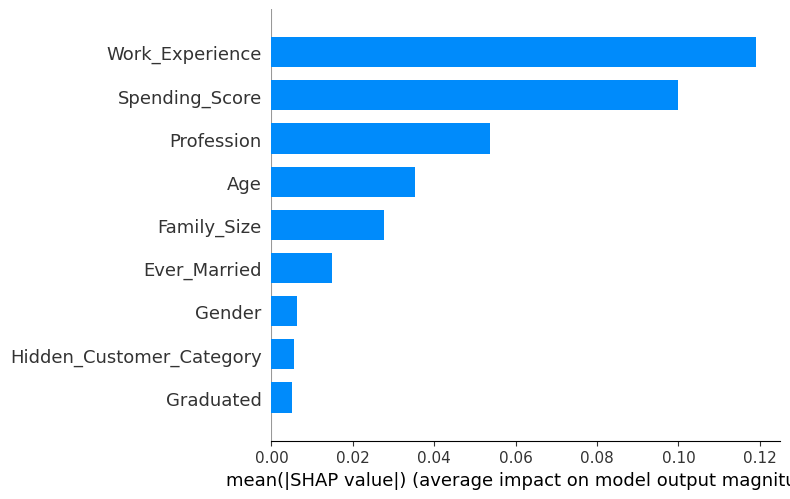

In [ ]:
# Sample a small subset of X_test
small_X_test = X_test.sample(n=100, random_state=42)

# Explain the Random Forest Model
explainer_rf = shap.TreeExplainer(best_rf)

shap_values_rf = explainer_rf.shap_values(small_X_test)
shap_values_mean = np.mean(np.abs(shap_values_rf), axis=2)

print("SHAP Summary Plot (Mean Across All Classes)")
shap.summary_plot(
    shap_values_mean, small_X_test, plot_type="bar", feature_names=small_X_test.columns
)

**Question:** Briefly explain the most influential predictors for customer segmentation, based on SHAP value.

**Answer:**

//

tbd

\\
---

#### **FLAML AutoML for Multi-Class Classification**  
Train models using **FLAML AutoML**, an efficient and lightweight AutoML framework.  


In [ ]:
# Initialize FLAML AutoML
automl = AutoML()

# Train AutoML with time limit
automl.fit(X_train, y_train, task="classification", time_budget=300)

# Get predictions from the best model
y_pred_flaml = automl.predict(X_test)

# Evaluate model performance
print("FLAML AutoML Accuracy:", accuracy_score(y_test, y_pred_flaml))
print(
    "FLAML AutoML Classification Report:\n", classification_report(y_test, y_pred_flaml)
)

# Print the best model selected by FLAML
print("\nFLAML AutoML Best Model:", automl.model.estimator)

[flaml.automl.logger: 03-06 14:50:44] {1728} INFO - task = classification
[flaml.automl.logger: 03-06 14:50:44] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 03-06 14:50:44] {1838} INFO - Minimizing error metric: log_loss
[flaml.automl.logger: 03-06 14:50:44] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'lrl1']
[flaml.automl.logger: 03-06 14:50:44] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 03-06 14:50:44] {2393} INFO - Estimated sufficient time budget=1140s. Estimated necessary time budget=26s.
[flaml.automl.logger: 03-06 14:50:44] {2442} INFO -  at 0.1s,	estimator lgbm's best error=1.0504,	best estimator lgbm's best error=1.0504
[flaml.automl.logger: 03-06 14:50:44] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 03-06 14:50:44] {2442} INFO -  at 0.2s,	estimator lgbm's best error=1.0504,	best estimator lgbm's best error=1.0504
[flaml.automl.logger: 03-06 1

[flaml.automl.logger: 03-06 14:50:45] {2442} INFO -  at 1.1s,	estimator sgd's best error=1.2043,	best estimator lgbm's best error=0.8964
[flaml.automl.logger: 03-06 14:50:45] {2258} INFO - iteration 4, current learner lgbm
[flaml.automl.logger: 03-06 14:50:45] {2258} INFO - iteration 4, current learner lgbm
[flaml.automl.logger: 03-06 14:50:45] {2442} INFO -  at 1.3s,	estimator lgbm's best error=0.6375,	best estimator lgbm's best error=0.6375
[flaml.automl.logger: 03-06 14:50:45] {2258} INFO - iteration 5, current learner xgboost
[flaml.automl.logger: 03-06 14:50:45] {2442} INFO -  at 1.5s,	estimator xgboost's best error=1.1927,	best estimator lgbm's best error=0.6375
[flaml.automl.logger: 03-06 14:50:45] {2258} INFO - iteration 6, current learner lgbm
[flaml.automl.logger: 03-06 14:50:46] {2442} INFO -  at 1.7s,	estimator lgbm's best error=0.6028,	best estimator lgbm's best error=0.6028
[flaml.automl.logger: 03-06 14:50:46] {2258} INFO - iteration 7, current learner lgbm
[flaml.automl

**Question:** Did FLAML AutoML provide better performance compared to manually tuned models? Briefly explain.

**Answer:**

//

tbd

\\
---

 # Short-Answer Questions

* Question 1 : You are part of the marketing team at a subscription-based service (e.g., streaming platform). The goal is to predict whether a user will subscribe to a premium plan based on their usage patterns and demographics. You’re using a machine learning model to predict subscription likelihood (Class 1: Subscribe, Class 0: No Subscribe).

**How would you prioritize precision or recall for a subscription service when targeting users for a premium plan?**

//

tbd

\\
---

* Question 2: You are working for an e-commerce company and have built a classification model to segment customers into high, medium, and low-value groups based on their likelihood of making future purchases (Class 1: High-Value, Class 2: Medium-Value, Class 3: Low-Value).

**Is it likely that data imbalance issues will occur, and what precautions should be taken when interpreting the results?**

//

tbd

\\
---

- Question 3: Dynamic Pricing Model for Airline Industry
You work at an airline, and the company uses a model to predict whether a customer will purchase a flight ticket at a given price (Class 1: Purchase, Class 0: No Purchase). The price changes dynamically based on factors like demand, booking time, and competitor pricing.

**How would you adjust your model's decision threshold to optimize for maximum profit in this dynamic pricing scenario? What considerations should you take into account when setting this threshold?**

//

tbd

\\
---

* Question 4: You work for an online payment company and are tasked with building a model to identify fraudulent transactions (Class 1: Fraud, Class 0: Legitimate). The dataset contains transaction amounts, user behavior, and historical fraud data.

**How would you use model explainability tools like SHAP or partial dependence plots to communicate the rationale behind the model's decisions to stakeholders who may not be familiar with machine learning?**

//

tbd

\\
---

**Question 5:
Supervised learning is widely used in business applications to make data-driven decisions.**

**Task:**


1. Identify a real-world business case where supervised learning can be applied.
Define the outcome variable (target variable) for this problem.

2. Explain how you would evaluate the model's performance:
Which evaluation metrics (e.g., Accuracy, Precision, Recall, F1-score, RMSE, AUC-ROC) would you choose?

3. Justify why those metrics are the most appropriate for your chosen business case.



💡 Hint: Consider cases like customer churn prediction, fraud detection, loan default prediction, or sales forecasting. Think about the cost of errors and which metric best captures the business objective.


//

tbd

\\
---